<p style="font-size:36px;text-align:center"> <b>Personalized cancer diagnosis</b> </p>

<h2>Objective:</h2>
    <h3> Applying machine learning models on top 1000 words obtained from text feature using Tf-Idf. </h3>
    <h3> As this task involves Tf-Idf, removed all the code related to EDA and Response coding of features </h3>

<h2>All the results are obtained from Tf_Idf vectorizing of features</h2>
<h3>Findings: </h3>
<table style=width:80%>
  <tr>
    <th>Model Name</th>
    <th>Log Loss Train</th> 
    <th>Log Loss CV</th>
    <th>Log Loss Test</th>
    <th>% of Misclassified Points</th>  
  </tr>
  <tr>
    <td>Naive Bayes</td>
    <td>0.499</td> 
    <td>1.217</td>
    <td>1.209</td>
    <td>40.41</td>  
  </tr>
  <tr>
    <td>KNN</td>
    <td>1.171</td> 
    <td>1.321</td>
    <td>1.288</td>
    <td>50.93</td>  
  </tr>
  <tr>
    <td>LR With Class Balancing</td>
    <td>0.404</td> 
    <td>1.189</td>
    <td>1.042</td>
    <td>37.96</td>  
  </tr>
  <tr>
    <td>LR Without Class Balancing</td>
    <td>0.398</td> 
    <td>1.222</td>
    <td>1.062</td>
    <td>38.53</td>  
  </tr>
  <tr>
    <td>LR SVM</td>
    <td>0.402</td> 
    <td>1.134</td>
    <td>1.042</td>
    <td>36.84</td>  
  </tr>
  <tr>
    <td>Random Forest</td>
    <td>0.896</td> 
    <td>1.184</td>
    <td>1.187</td>
    <td>40.97</td>  
  </tr>
  <tr>
    <td>Stacking classifier</td>
    <td>0.514</td> 
    <td>1.260</td>
    <td>1.231</td>
    <td>41.95</td>  
  </tr>
  <tr>
    <td>Voting classifier</td>
    <td>0.841</td> 
    <td>1.221</td>
    <td>1.219</td>
    <td>39.84</td>  
  </tr>  
    
</table>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

C:\Users\rahul\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


<h2>1. Reading Data</h2>

<h3>Reading Gene and Variation Data</h3>

In [2]:
data = pd.read_csv('training/training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


<p>
    training/training_variants is a comma separated file containing the description of the genetic mutations used for training. <br>
    Fields are 
    <ul>
        <li><b>ID : </b>the id of the row used to link the mutation to the clinical evidence</li>
        <li><b>Gene : </b>the gene where this genetic mutation is located </li>
        <li><b>Variation : </b>the aminoacid change for this mutations </li>
        <li><b>Class :</b> 1-9 the class this genetic mutation has been classified on</li>
    </ul>

<h3>Reading Text Data</h3>

In [3]:
# note the seprator in this file
data_text =pd.read_csv("training/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


<h3> Preprocessing of text</h3>

In [4]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        # replace every special char with space
        if type(total_text) is not float:
            string = ""
            total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
            # replace multiple spaces with single space
            total_text = re.sub('\s+',' ', total_text)
            # converting all the chars into lower-case.
            total_text = total_text.lower()

            for word in total_text.split():
            # if the word is a not a stop word then retain that word from the data
                if not word in stop_words:
                    string += word + " "

            data_text[column][index] = string

In [5]:
#text processing stage.
start_time = time.clock()
for index, row in data_text.iterrows():
    nlp_preprocessing(row['TEXT'], index, 'TEXT')
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

Time took for preprocessing the text : 136.35273206320105 seconds


In [7]:
#merging both gene_variations and text data based on ID
result = pd.merge(data, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


<h3>Test, Train and Cross Validation Split</h3>

In [8]:
np.array(np.where(result['TEXT'].isnull().values==True))

array([[1109, 1277, 1407, 1639, 2755]], dtype=int64)

In [9]:
for i in np.array(np.where(result['TEXT'].isnull().values==True)):
    result['TEXT'][i]='empty'

In [10]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [11]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


In [12]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
   
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

<h2>2. Vectorizing  Data</h2>

In [52]:
def getTopWordsFrom_TfIdf_Value(tf_idf_vect,final_tf_idf):
    feature_array = np.array(tf_idf_vect.get_feature_names())
    final_tf_idf_arr=final_tf_idf.toarray().sum(axis=0)
    
    top_1k_index=np.argsort(final_tf_idf_arr)[::-1]
    top_1k_index=top_1k_index[0:1000]
    complete_most_imp_words=feature_array[top_1k_index]
    most_imp_words_subset=complete_most_imp_words[0:1000]
    
    return most_imp_words_subset,top_1k_index

In [53]:
tf_idf_vect = TfidfVectorizer(min_df=3)
train = tf_idf_vect.fit_transform(train_df['TEXT'])
cv = tf_idf_vect.transform(cv_df['TEXT'])
test = tf_idf_vect.transform(test_df['TEXT'])

In [54]:
top1000_words_train,top_1000_index=getTopWordsFrom_TfIdf_Value(tf_idf_vect,train)

In [64]:
print('Top 5 words : %s' %(top1000_words_train[0:5]))

train_text_feature = train[:,top_1000_index]
cv_text_feature = cv[:,top_1000_index]
test_text_feature = test[:,top_1000_index]

print("Number of words in train data = ", train_text_feature.shape)
print("Number of words in test data = ", test_text_feature.shape)
print("Number of words in cross validation data =", cv_text_feature.shape)

Top 5 words : ['mutations' 'brca1' 'cells' 'variants' 'fig']
Number of words in train data =  (2124, 1000)
Number of words in test data =  (665, 1000)
Number of words in cross validation data = (532, 1000)


In [65]:
gene_vectorizer = TfidfVectorizer()
train_gene_feature = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature = gene_vectorizer.transform(cv_df['Gene'])

var_vectorizer = TfidfVectorizer()
train_variation_feature = gene_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature = gene_vectorizer.transform(test_df['Variation'])
cv_variation_feature = gene_vectorizer.transform(cv_df['Variation'])

In [66]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [67]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [68]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = TfidfVectorizer()
    var_count_vec = TfidfVectorizer()
    text_count_vec = TfidfVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = tf_idf_vect.fit(train_df['TEXT'])
    
    #text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

<p style="font-size:24px;text-align:Center"> <b>Stacking the three types of features </b><p>

In [69]:
train_gene_var= hstack((train_gene_feature,train_variation_feature))
test_gene_var = hstack((test_gene_feature,test_variation_feature))
cv_gene_var = hstack((cv_gene_feature,cv_variation_feature))

train_x = hstack((train_gene_var, train_text_feature)).tocsr()
test_x = hstack((test_gene_var, test_text_feature)).tocsr()
cv_x = hstack((cv_gene_var, cv_text_feature)).tocsr()

train_x = normalize(train_x, axis=0)
test_x = normalize(test_x, axis=0)
cv_x = normalize(cv_x, axis=0)

test_y = np.array(list(test_df['Class']))
train_y = np.array(list(train_df['Class']))
cv_y = np.array(list(cv_df['Class']))



In [70]:
print("(number of data points * number of features) in train data = ", train_x.shape)
print("(number of data points * number of features) in test data = ", test_x.shape)
print("(number of data points * number of features) in cross validation data =", cv_x.shape)

(number of data points * number of features) in train data =  (2124, 3178)
(number of data points * number of features) in test data =  (665, 3178)
(number of data points * number of features) in cross validation data = (532, 3178)


<h1> #######  Machine Learning Models  ########</h1>

<h2>3. Base Line Model : Naive Bayes</h2>

<h4>3.1 Hyper parameter tuning</h4>

for alpha = 1e-05
Log Loss : 1.2208026711228506
for alpha = 0.0001
Log Loss : 1.2181281348283466
for alpha = 0.001
Log Loss : 1.2171050198142706
for alpha = 0.1
Log Loss : 1.2911033083779635
for alpha = 1
Log Loss : 1.4810246564163594
for alpha = 10
Log Loss : 1.8488988917814526
for alpha = 100
Log Loss : 1.9637463130835202
for alpha = 1000
Log Loss : 1.9300426926868242


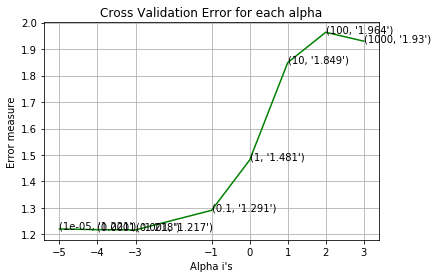

For values of best alpha =  0.001 The train log loss is: 0.4992922571287662
For values of best alpha =  0.001 The cross validation log loss is: 1.2171050198142706
For values of best alpha =  0.001 The test log loss is: 1.209927401067482


In [71]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, train_y)


predict_y = sig_clf.predict_proba(train_x)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<h4>3.2 Testing the model with best hyper paramters</h4>

Log Loss : 1.2171050198142706
Number of missclassified point : 0.4041353383458647
-------------------- Confusion matrix --------------------


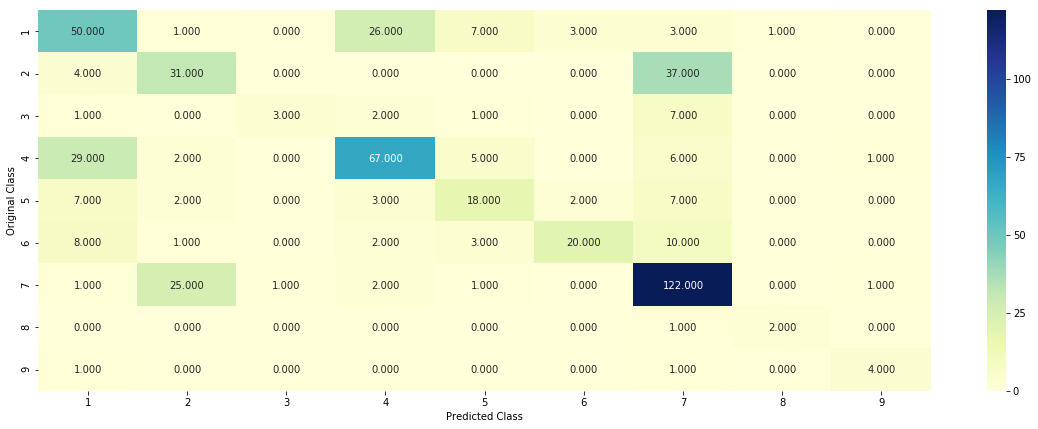

-------------------- Precision matrix (Columm Sum=1) --------------------


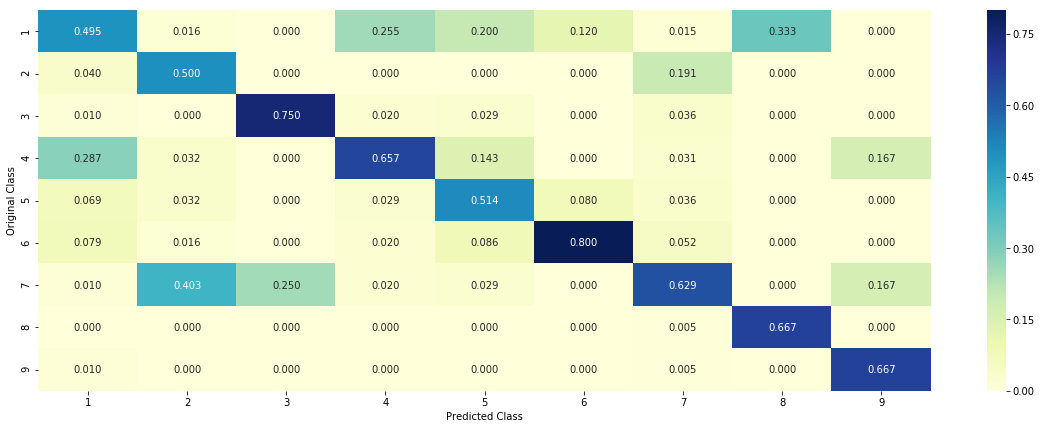

-------------------- Recall matrix (Row sum=1) --------------------


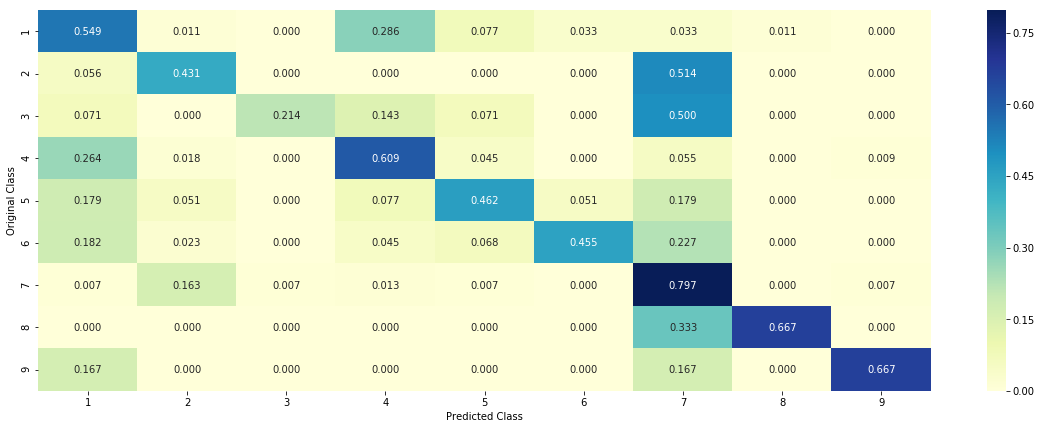

In [72]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x.toarray()))

<h4>3.3 Feature Importance</h4>

In [73]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 6
Predicted Class Probabilities: [[0.0503 0.0375 0.0093 0.06   0.0341 0.7378 0.0648 0.0033 0.0029]]
Actual Class : 6
--------------------------------------------------
14 Text feature [08] present in test data point [True]
18 Text feature [129] present in test data point [True]
20 Text feature [11] present in test data point [True]
41 Text feature [000] present in test data point [True]
53 Text feature [11t] present in test data point [True]
70 Text feature [005] present in test data point [True]
80 Text feature [104] present in test data point [True]
82 Text feature [121] present in test data point [True]
Out of the top  100  features  8 are present in query point


<h2>4. K Nearest Neighbour Classification</h2>

<h3>4.1 Hyper parameter tuning</h3>

for alpha = 5
Log Loss : 1.3484634333808607
for alpha = 11
Log Loss : 1.3283498202878024
for alpha = 15
Log Loss : 1.3366192285609584
for alpha = 21
Log Loss : 1.355138666452647
for alpha = 31
Log Loss : 1.351730909346724
for alpha = 41
Log Loss : 1.3899658692510175
for alpha = 51
Log Loss : 1.405611786325036
for alpha = 99
Log Loss : 1.321643532459392


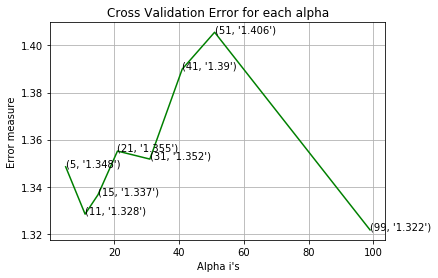

For values of best alpha =  99 The train log loss is: 1.171629602208783
For values of best alpha =  99 The cross validation log loss is: 1.321643532459392
For values of best alpha =  99 The test log loss is: 1.28840223333146


In [75]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, train_y)

predict_y = sig_clf.predict_proba(train_x)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<h3>4.2 Testing the model with best hyper paramters</h3>

Log loss : 1.321643532459392
Number of mis-classified points : 0.5093984962406015
-------------------- Confusion matrix --------------------


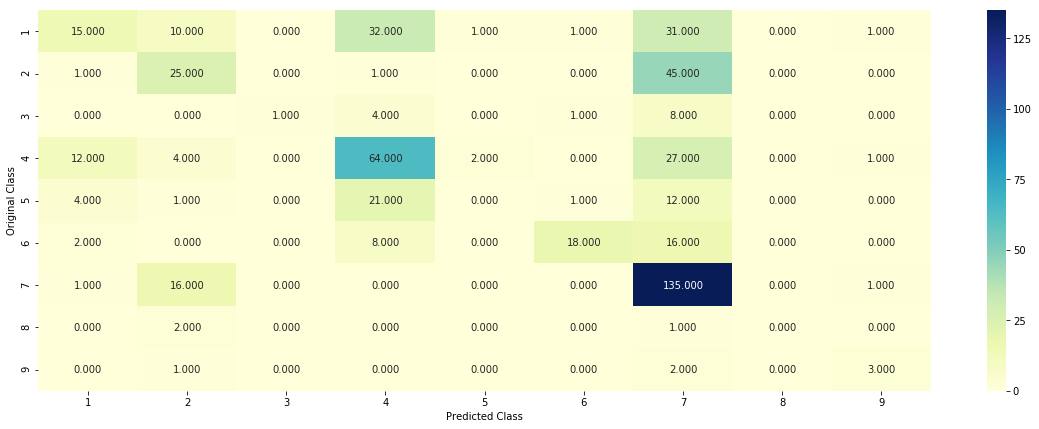

-------------------- Precision matrix (Columm Sum=1) --------------------


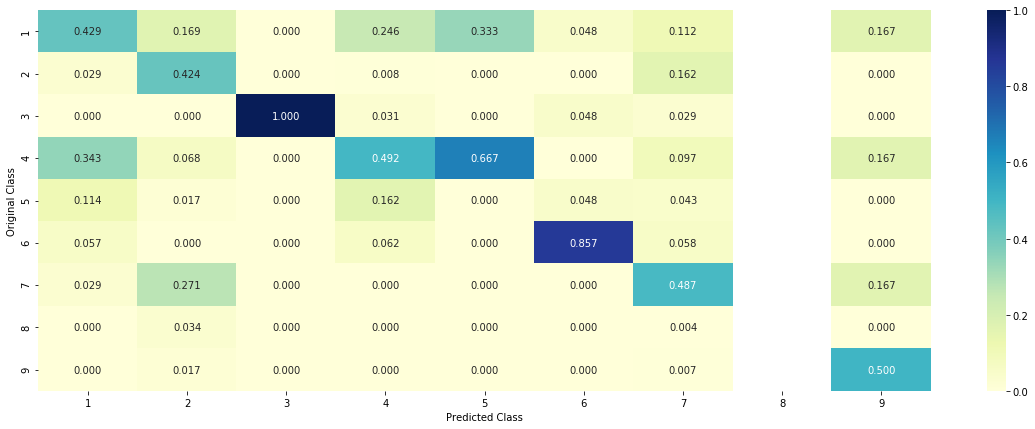

-------------------- Recall matrix (Row sum=1) --------------------


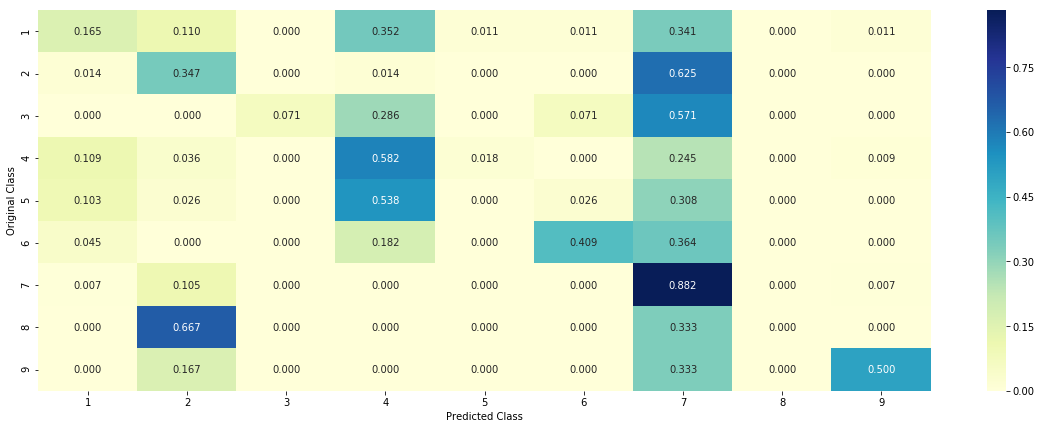

In [76]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x, train_y, cv_x, cv_y, clf)

<h3>4.3 Sample Query point -1</h3>

In [77]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 6
The  99  nearest neighbours of the test points belongs to classes [6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 1 1 5
 4 4 1 5 1 2 7 2 1 1 4 7 7 1 1 1 1 1 2 4 1 1 1 1 2 1 4 1 4 1 1 1 1 1 1 1 1
 7 7 1 2 1 1 7 7 1 1 7 7 2 6 2 2 2 2 7 7 1 2 1 5 5]
Fequency of nearest points : Counter({1: 32, 6: 31, 2: 11, 7: 11, 5: 8, 4: 6})


<h2>5. Logistic Regression</h2>

<h3>5.1. With Class balancing</h3>

<h4>5.1.1 Hyper paramter tuning</h4>

for alpha = 1e-06
Log Loss : 1.1978147752970956
for alpha = 1e-05
Log Loss : 1.195133520144548
for alpha = 0.0001
Log Loss : 1.1892420809520745
for alpha = 0.001
Log Loss : 1.2436214776956505
for alpha = 0.01
Log Loss : 1.5317410299496368
for alpha = 0.1
Log Loss : 1.822492094508599
for alpha = 1
Log Loss : 1.8569491537915577
for alpha = 10
Log Loss : 1.8606191950343358
for alpha = 100
Log Loss : 1.8610104496074953


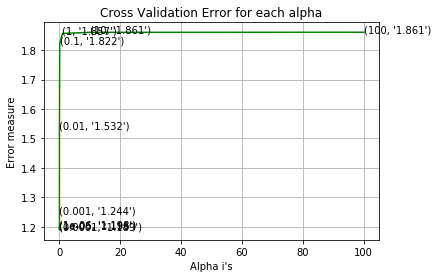

For values of best alpha =  0.0001 The train log loss is: 0.40479902133011536
For values of best alpha =  0.0001 The cross validation log loss is: 1.1892420809520745
For values of best alpha =  0.0001 The test log loss is: 1.042078560972827


In [78]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, train_y)

predict_y = sig_clf.predict_proba(train_x)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h4>5.1.2. Testing the model with best hyper paramters</h4>

Log loss : 1.1892420809520745
Number of mis-classified points : 0.37969924812030076
-------------------- Confusion matrix --------------------


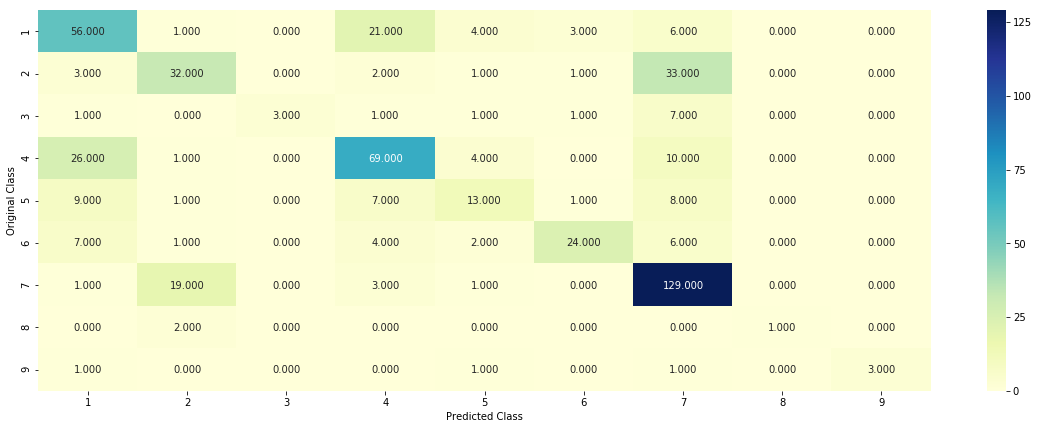

-------------------- Precision matrix (Columm Sum=1) --------------------


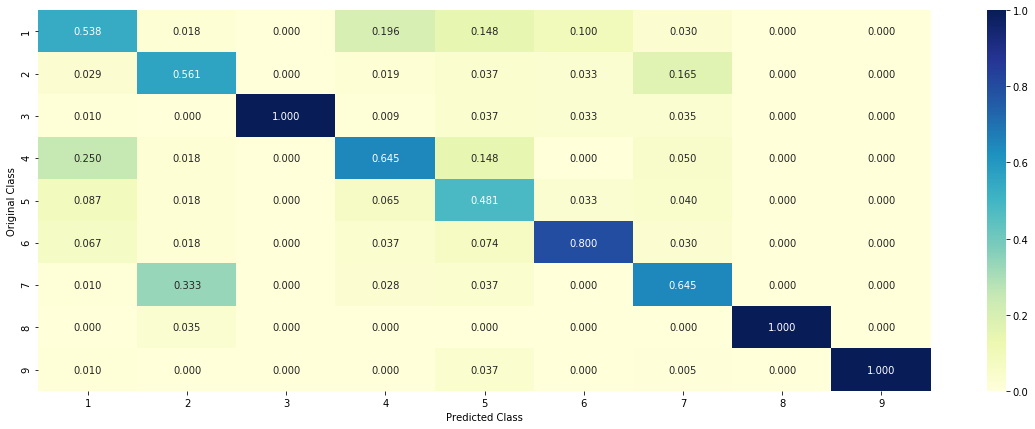

-------------------- Recall matrix (Row sum=1) --------------------


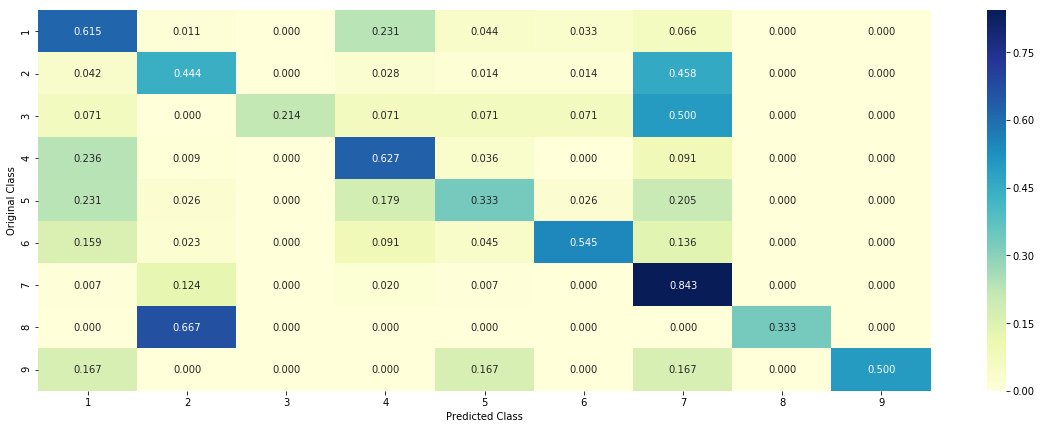

In [79]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x, train_y, cv_x, cv_y, clf)

<h4>5.1.3. Feature Importance</h4>

<h5> Correctly Classified point</h5>

In [80]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 6
Predicted Class Probabilities: [[2.400e-03 5.000e-04 0.000e+00 9.000e-04 1.990e-02 9.761e-01 0.000e+00
  2.000e-04 0.000e+00]]
Actual Class : 6
--------------------------------------------------
101 Text feature [000] present in test data point [True]
130 Text feature [1011] present in test data point [True]
195 Text feature [109] present in test data point [True]
203 Text feature [117] present in test data point [True]
207 Text feature [11] present in test data point [True]
247 Text feature [0other] present in test data point [True]
320 Text feature [121] present in test data point [True]
349 Text feature [129] present in test data point [True]
354 Text feature [08] present in test data point [True]
360 Text feature [110] present in test data point [True]
392 Text feature [071] present in test data point [True]
403 Text feature [049] present in test data point [True]
415 Text feature [106] present in test data point [True]
426 Text feature [11t] present in test dat

<h3>5.2. Without Class balancing</h3>

<h4>5.2.1. Hyper paramter tuning</h4>

for alpha = 1e-06
Log Loss : 1.2239402880000263
for alpha = 1e-05
Log Loss : 1.259084934495602
for alpha = 0.0001
Log Loss : 1.2226256781518945
for alpha = 0.001
Log Loss : 1.3859936748557027
for alpha = 0.01
Log Loss : 1.4561127210327203
for alpha = 0.1
Log Loss : 1.8270813300031394
for alpha = 1
Log Loss : 1.8717221598238392


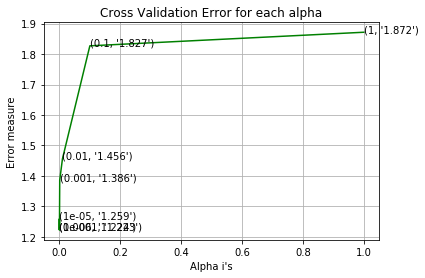

For values of best alpha =  0.0001 The train log loss is: 0.3989436662031939
For values of best alpha =  0.0001 The cross validation log loss is: 1.2226256781518945
For values of best alpha =  0.0001 The test log loss is: 1.062230293736422


In [82]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, train_y)

predict_y = sig_clf.predict_proba(train_x)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h4>5.2.2. Testing model with best hyper parameters</h4>

Log loss : 1.2226256781518945
Number of mis-classified points : 0.38533834586466165
-------------------- Confusion matrix --------------------


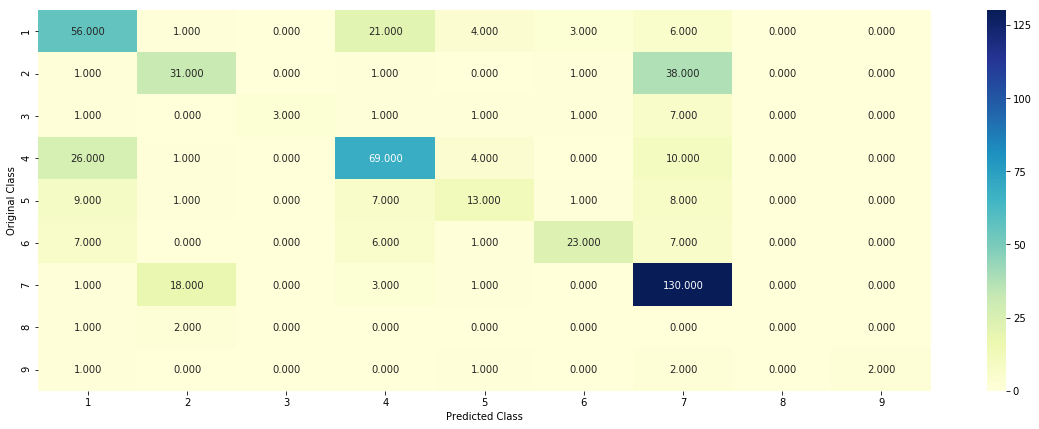

-------------------- Precision matrix (Columm Sum=1) --------------------


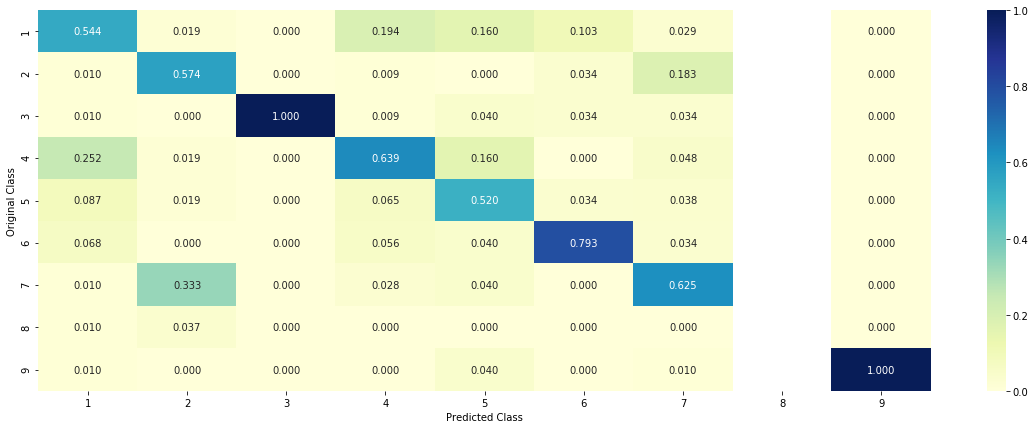

-------------------- Recall matrix (Row sum=1) --------------------


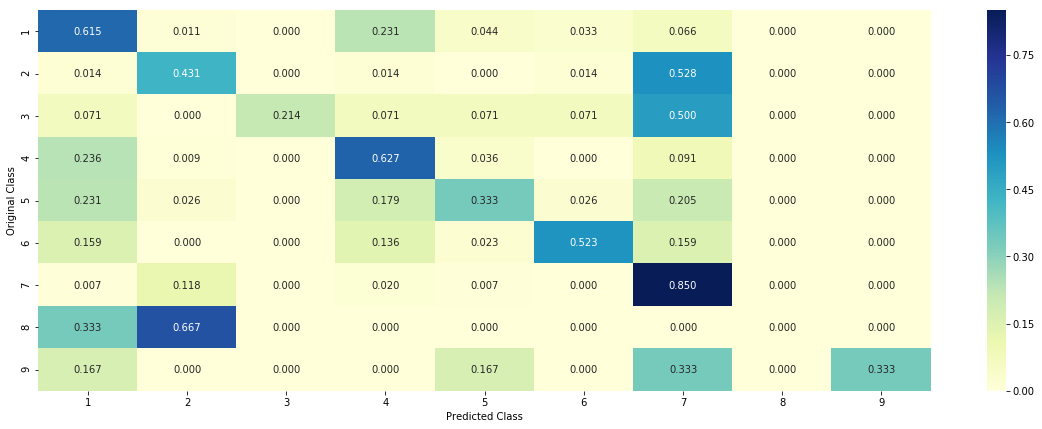

In [83]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x, train_y, cv_x, cv_y, clf)

<h4>5.2.3. Feature Importance, Correctly Classified point</h4>

In [84]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 6
Predicted Class Probabilities: [[2.800e-03 6.000e-04 0.000e+00 1.400e-03 1.820e-02 9.757e-01 0.000e+00
  1.300e-03 0.000e+00]]
Actual Class : 6
--------------------------------------------------
97 Text feature [000] present in test data point [True]
122 Text feature [1011] present in test data point [True]
197 Text feature [11] present in test data point [True]
203 Text feature [109] present in test data point [True]
212 Text feature [117] present in test data point [True]
261 Text feature [0other] present in test data point [True]
320 Text feature [121] present in test data point [True]
331 Text feature [129] present in test data point [True]
350 Text feature [08] present in test data point [True]
360 Text feature [110] present in test data point [True]
386 Text feature [071] present in test data point [True]
404 Text feature [049] present in test data point [True]
420 Text feature [11t] present in test data point [True]
421 Text feature [106] present in test data

<h2>6. Linear Support Vector Machines</h2>

<h3>6.1. Hyper paramter tuning</h3>

for C = 1e-05
Log Loss : 1.2282365512036957
for C = 0.0001
Log Loss : 1.1340008933490948
for C = 0.001
Log Loss : 1.1357070363346613
for C = 0.01
Log Loss : 1.295857913595936
for C = 0.1
Log Loss : 1.8629808948202617
for C = 1
Log Loss : 1.8610692102209205
for C = 10
Log Loss : 1.8610694437109632
for C = 100
Log Loss : 1.861069386951354


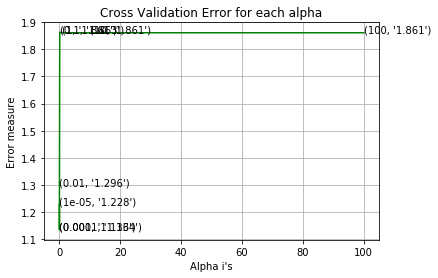

For values of best alpha =  0.0001 The train log loss is: 0.402889961074172
For values of best alpha =  0.0001 The cross validation log loss is: 1.1340008933490948
For values of best alpha =  0.0001 The test log loss is: 1.042558592735136


In [85]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, train_y)

predict_y = sig_clf.predict_proba(train_x)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h3>6.2. Testing model with best hyper parameters</h3>

Log loss : 1.1340008933490948
Number of mis-classified points : 0.3684210526315789
-------------------- Confusion matrix --------------------


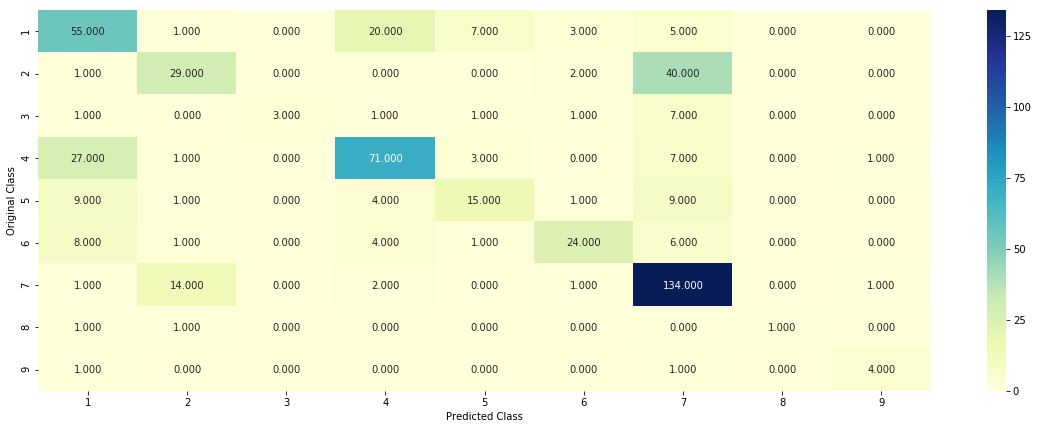

-------------------- Precision matrix (Columm Sum=1) --------------------


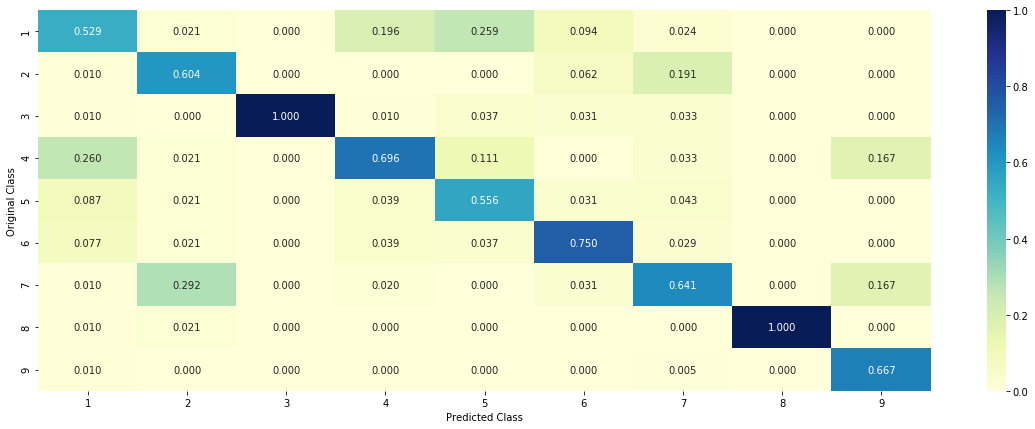

-------------------- Recall matrix (Row sum=1) --------------------


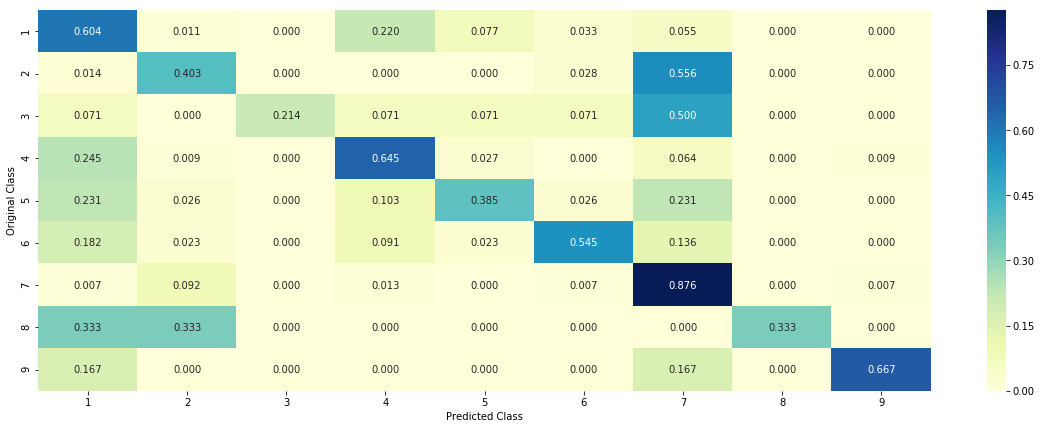

In [86]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x, train_y,cv_x,cv_y, clf)

<h3>6.3. Feature Importance</h3>

In [87]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x,train_y)
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 6
Predicted Class Probabilities: [[1.17e-02 1.44e-02 0.00e+00 1.54e-02 9.10e-03 9.47e-01 2.10e-03 2.00e-04
  0.00e+00]]
Actual Class : 6
--------------------------------------------------
187 Text feature [117] present in test data point [True]
196 Text feature [000] present in test data point [True]
207 Text feature [109] present in test data point [True]
214 Text feature [11] present in test data point [True]
222 Text feature [0other] present in test data point [True]
253 Text feature [1011] present in test data point [True]
260 Text feature [106] present in test data point [True]
289 Text feature [10g] present in test data point [True]
293 Text feature [11t] present in test data point [True]
303 Text feature [110] present in test data point [True]
348 Text feature [1010] present in test data point [True]
359 Text feature [059] present in test data point [True]
405 Text feature [121] present in test data point [True]
431 Text feature [100] present in test data point

<h2>7. Random Forest Classifier</h2>

<h3>7.1. Hyper paramter tuning </h3>

In [88]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

'''fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, train_y)

predict_y = sig_clf.predict_proba(train_x)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.1935479772873627
for n_estimators = 100 and max depth =  10
Log Loss : 1.2099091379949567
for n_estimators = 200 and max depth =  5
Log Loss : 1.1898245268913852
for n_estimators = 200 and max depth =  10
Log Loss : 1.206034882693002
for n_estimators = 500 and max depth =  5
Log Loss : 1.189079142034199
for n_estimators = 500 and max depth =  10
Log Loss : 1.2012418075494704
for n_estimators = 1000 and max depth =  5
Log Loss : 1.1841752098637048
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1992840732005354
for n_estimators = 2000 and max depth =  5
Log Loss : 1.1848188638083217
for n_estimators = 2000 and max depth =  10
Log Loss : 1.2003433697022823
For values of best estimator =  1000 The train log loss is: 0.8969859196172554
For values of best estimator =  1000 The cross validation log loss is: 1.1841752098637048
For values of best estimator =  1000 The test log loss is: 1.187205665158357


<h3>7.2. Testing model with best hyper parameters</h3>

Log loss : 1.1841752098637048
Number of mis-classified points : 0.40977443609022557
-------------------- Confusion matrix --------------------


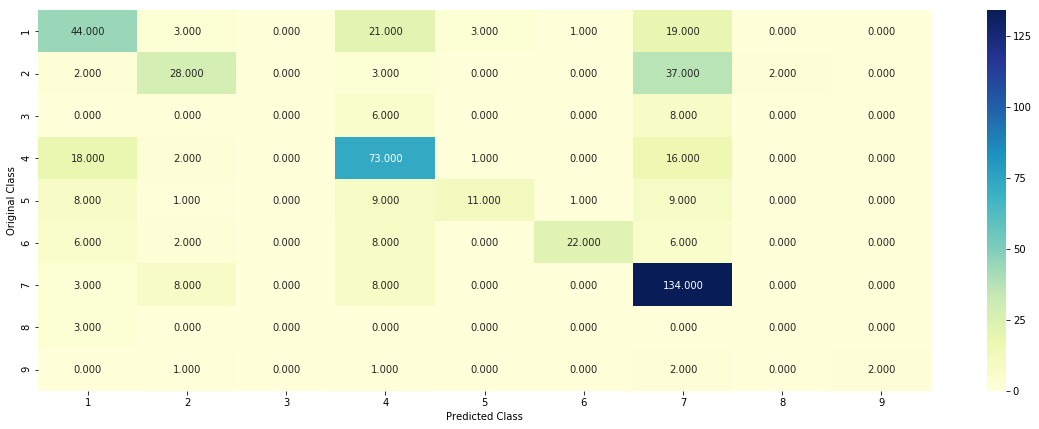

-------------------- Precision matrix (Columm Sum=1) --------------------


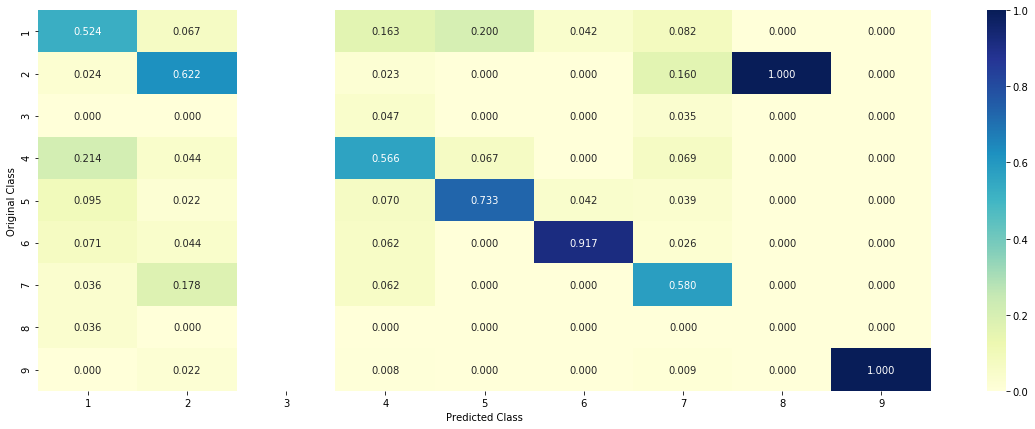

-------------------- Recall matrix (Row sum=1) --------------------


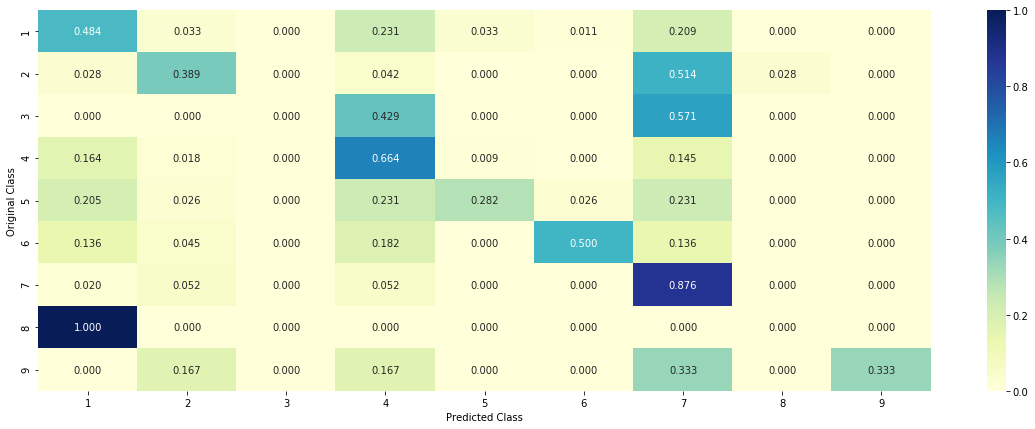

In [89]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x, train_y,cv_x,cv_y, clf)

<h3>7.3. Feature Importance</h3>

In [90]:
# test_point_index = 10
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 6
Predicted Class Probabilities: [[1.220e-02 3.800e-03 3.600e-03 8.300e-03 1.726e-01 7.893e-01 8.700e-03
  1.000e-03 4.000e-04]]
Actual Class : 6
--------------------------------------------------
5 Text feature [001] present in test data point [True]
19 Text feature [111] present in test data point [True]
25 Text feature [000] present in test data point [True]
73 Text feature [117] present in test data point [True]
78 Text feature [049] present in test data point [True]
81 Text feature [11] present in test data point [True]
Out of the top  100  features  6 are present in query point


<h2>8. Stack the models </h2>

<h3>8.1 testing with hyper parameter tuning</h3>

In [91]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x))))
sig_clf2.fit(train_x, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x))))
sig_clf3.fit(train_x, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.24
Support vector machines : Log Loss: 1.86
Naive Bayes : Log Loss: 1.22
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.178
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.033
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.521
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.260
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.559
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 2.052


<h3>8.2 testing the model with the best hyper parameters</h3>

Log loss (train) on the stacking classifier : 0.5142099912528459
Log loss (CV) on the stacking classifier : 1.260273867435053
Log loss (test) on the stacking classifier : 1.2315622360944372
Number of missclassified point : 0.4195488721804511
-------------------- Confusion matrix --------------------


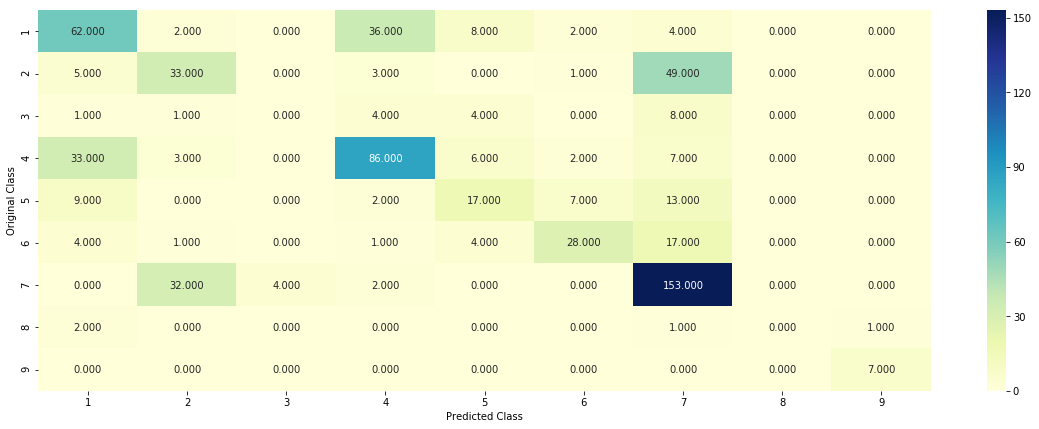

-------------------- Precision matrix (Columm Sum=1) --------------------


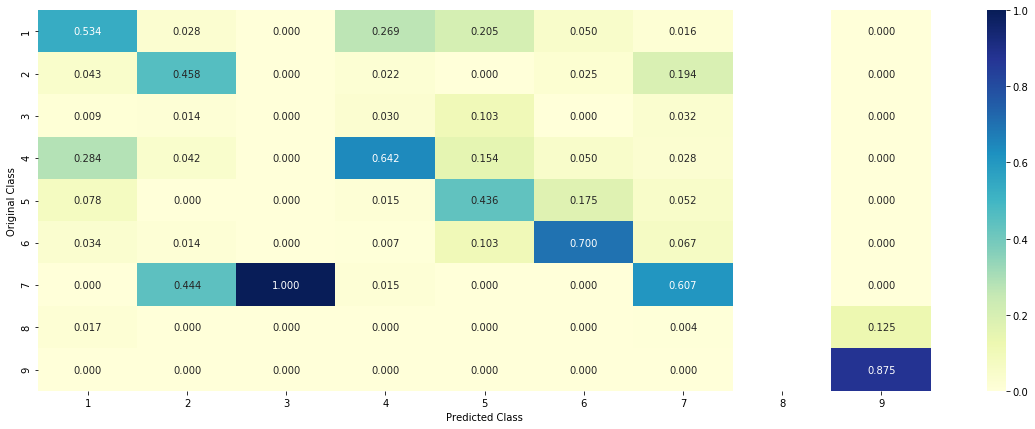

-------------------- Recall matrix (Row sum=1) --------------------


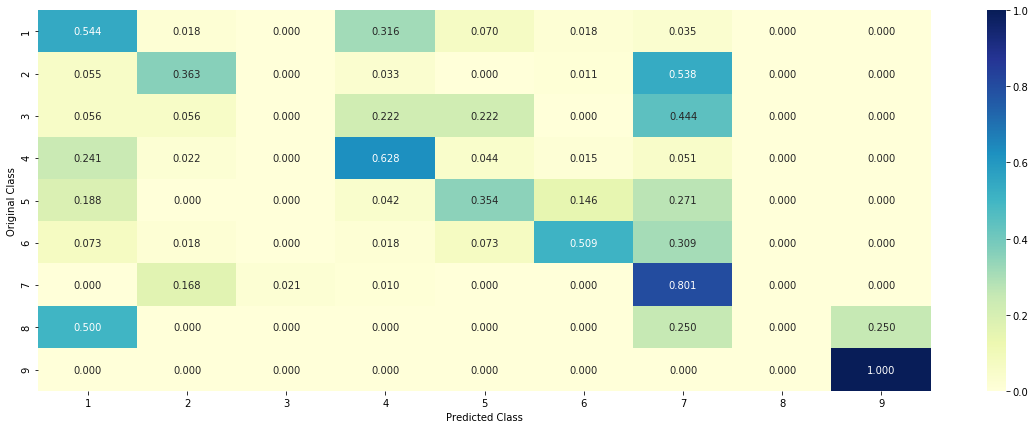

In [92]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x))

<h3>9. Maximum Voting classifier </h3>

Log loss (train) on the VotingClassifier : 0.8412047871158591
Log loss (CV) on the VotingClassifier : 1.221072964163098
Log loss (test) on the VotingClassifier : 1.219646471901804
Number of missclassified point : 0.39849624060150374
-------------------- Confusion matrix --------------------


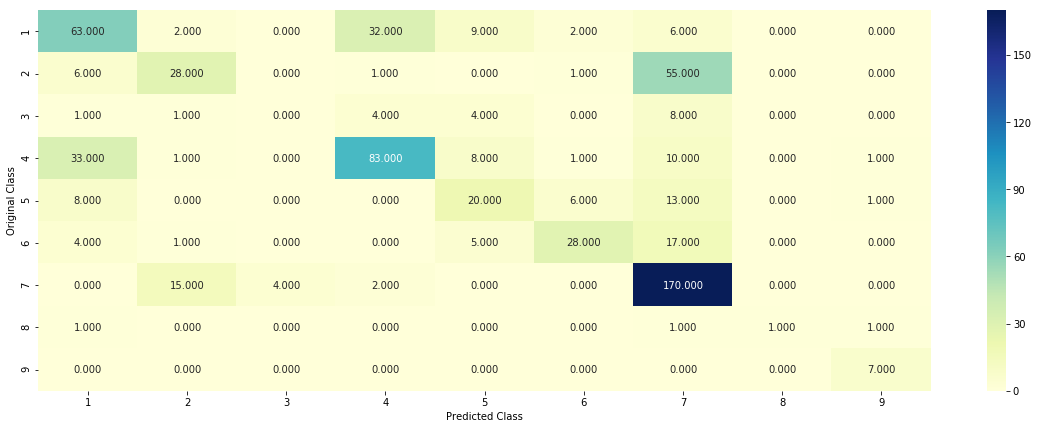

-------------------- Precision matrix (Columm Sum=1) --------------------


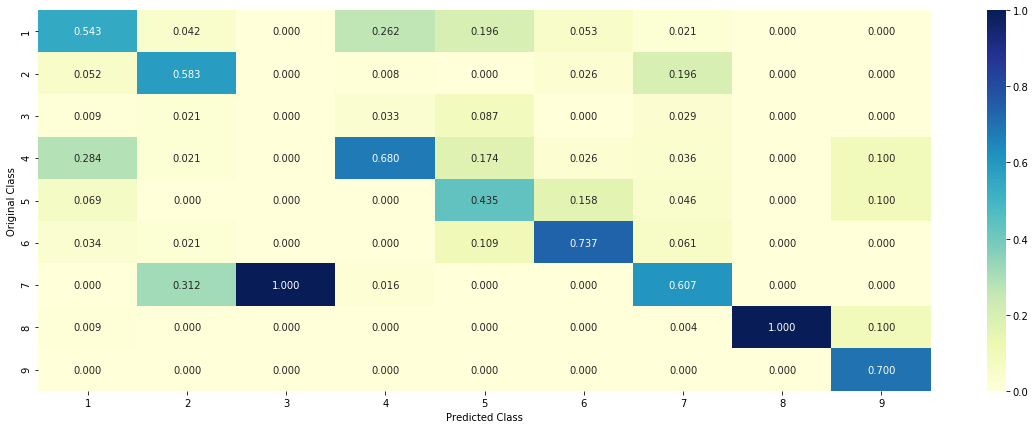

-------------------- Recall matrix (Row sum=1) --------------------


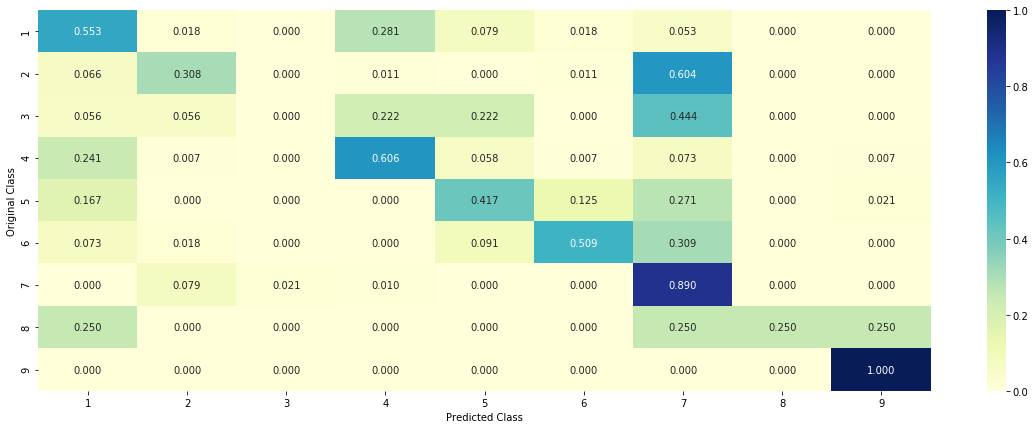

In [93]:
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x))